# Battle of the Neighborhoods Capstone Project

## Introduction / Business Problem

<b>Stakeholders:</b> Restaurant investors

<b>Problem:</b> Starting new chain of Vietnamse Pho restaurants in Chicago

<b>Target:</b> Find neighborhoods where opening a restaurant would be profitable

Opening new restaurants are difficult to do, especially in neighborhoods that have not had a particular cuisine available so close before. Due to the size and diversity of Chicago, our problem is to find those neighborhoods where we will have low amount of competitors (other Asian restaurants). We want to avoid neighborhoods where they are saturated with Asian cuisines, nor are close to other neighborhoods with Asian cuisines as their top restaurant.

What can we leverage to find those neighborhoods? Using Foursquare data, we should analysis what is in each neighborhood in term of restaurants.

## <b>Data</b>

1. Neighborhoods in Chicago and their locations</br>
    a. Neighborhoods and locations will be pulled from Wikipedia</br>
    b. Location data will be used to divide Chicago into neighborhoods as well as feed into Foursquare API to obtain information regarding each neighborhood</br>
2. Venues data from Foursquare</br>
3. If possible, get census data for each neighborhood

### How Data is applied

Using the data described above, we first find the top 5 venues at each neighborhood. We want to eliminate any neighborhoods where the 3 are any Asian cuisine, but those where the top 5 venues are coffee shops and ice cream. Why have coffee and ice cream at the top? Because some of the top selling items in a Vietnamese restaurant, outside of pho, is the iced coffee and boba tea; so in a neighborhood that enjoys their coffee and ice cream, the coffee and boba tea would do quite well.

Why seek census data? It will be used to create unique pho fusions. For instance, in Texas, there are restaurants that have merged the flavor of Tex-Mex with pho. If we can determine that a neighborhood is predominately Latin, we can bring Latin flair to the pho; but if the neighborhood is predominately German, we can bring a German flair to the pho. This will allow our restaurants to stand out from every other generic pho restaurant.

In [4]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

Obtain data from source that have lat/long and zipcode for areas around chicago

In [5]:
source = requests.get('http://www.geonames.org/postal-codes/US/IL/illinois.html').text

soup = BeautifulSoup(source,'lxml')

In [6]:
column_names = ['City','County','Zipcode','Latitude','Longitude']

neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,City,County,Zipcode,Latitude,Longitude


In [7]:
neigh_loc = soup.find('table', class_='restable').find_all('tr')[1:]

i = 0

for row in neigh_loc:
    cells = row.find_all("td")
    
    if len(cells) == 7:
        neighborhoods.loc[i] = [cells[1].text, cells[5].text, cells[2].text,'','']

        
        
    if len(cells) == 2:
        neighborhoods.loc[i,'Latitude'] = cells[1].text.split("/")[0]
        neighborhoods.loc[i,'Longitude'] = cells[1].text.split("/")[1]
        i = i + 1
        
neighborhoods["Latitude"] = neighborhoods["Latitude"].astype("float")
neighborhoods["Longitude"] = neighborhoods["Longitude"].astype("float")
        
neighborhoods.head()

,City,County,Zipcode,Latitude,Longitude
0,Chicago,Cook,60601,41.886,-87.618
1,Chicago,Cook,60603,41.880,-87.628
2,Chicago,Cook,60605,41.871,-87.628
3,Chicago,Cook,60606,41.887,-87.639
4,Chicago,Cook,60607,41.872,-87.658


In [8]:
client_id = 'TGCQGSJKJH12NXVL241OAUEHDVGPHHREGXN55S320W3K1XDW'
client_sec = 'D2WSWV23UFUYY0YTWOFUKH4PNGBJROD2SKJZDR2HDO13EFW5'
ver = '20180605'

limit = 100

In [9]:
import requests
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_sec, 
            ver, 
            lat, 
            lng, 
            radius, 
            limit)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
#neighborhoods.dtypes
chicago_venues = getNearbyVenues(names=neighborhoods['City'],latitudes=neighborhoods['Latitude'],longitudes=neighborhoods['Longitude'])

In [11]:
chicago_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chicago,41.886,-87.618,Lakeshore East Park,41.886081,-87.617769,Park
1,Chicago,41.886,-87.618,Mariano's,41.885326,-87.618923,Grocery Store
2,Chicago,41.886,-87.618,Eggy's,41.885517,-87.618902,Diner
3,Chicago,41.886,-87.618,"Radisson Blu Aqua Hotel, Chicago, IL",41.886428,-87.620010,Hotel
4,Chicago,41.886,-87.618,Lakeshore East Dog Park,41.885752,-87.618498,Dog Run


In [12]:
venue_counts = chicago_venues.groupby('City').count()
print(venue_counts.shape)
venue_counts.head(25)


(131, 6)


,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Addison,12,12,12,12,12,12
Alden,3,3,3,3,3,3
Algonquin,6,6,6,6,6,6
Antioch,3,3,3,3,3,3
Arlington Heights,74,74,74,74,74,74
Barrington,27,27,27,27,27,27
Bartlett,19,19,19,19,19,19
Beecher,1,1,1,1,1,1
Bellwood,13,13,13,13,13,13


In [13]:
chicago_oh = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")
chicago_oh['City'] = chicago_venues['City']
fixed_columns = [chicago_oh.columns[-1]] + list(chicago_oh.columns[:-1])
chicago_oh = chicago_oh[fixed_columns]
chicago_oh.head()

,City,ATM,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Chicago,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Chicago,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Chicago,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Chicago,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Chicago,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
chicago_oh.shape

(2308, 297)

In [15]:
chicago_gr = chicago_oh.groupby('City').mean().reset_index()
chicago_gr.head()

,City,ATM,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Addison,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Alden,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,Algonquin,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Antioch,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Arlington Heights,0.0,0.013514,0.0,0.0,0.0,0.0,0.013514,0.0,0.0,...,0.013514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027027,0.0


In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

chicago_venues_sorted = pd.DataFrame(columns=columns)
chicago_venues_sorted['City'] = chicago_gr['City']

for ind in np.arange(chicago_gr.shape[0]):
    chicago_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_gr.iloc[ind, :], num_top_venues)

chicago_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Addison,Cosmetics Shop,Fast Food Restaurant,Hookah Bar,Gym / Fitness Center,Breakfast Spot
1,Alden,Tennis Court,Playground,Burger Joint,Yoga Studio,Electronics Store
2,Algonquin,Home Service,Irish Pub,Park,Jewelry Store,Construction & Landscaping
3,Antioch,Home Service,Ice Cream Shop,Health & Beauty Service,Electronics Store,Dive Spot
4,Arlington Heights,Cosmetics Shop,Pet Store,Bar,Sporting Goods Shop,Shipping Store


In [21]:
cities_with_size = venue_counts[venue_counts["Venue"]>=5]
cities_with_size.reset_index(level=0, inplace=True)
cities_with_size.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Addison,12,12,12,12,12,12
1,Algonquin,6,6,6,6,6,6
2,Arlington Heights,74,74,74,74,74,74
3,Barrington,27,27,27,27,27,27
4,Bartlett,19,19,19,19,19,19


In [22]:
restricted_cities = chicago_venues_sorted[chicago_venues_sorted["City"].isin(cities_with_size["City"])]
restricted_cities.shape

(85, 6)

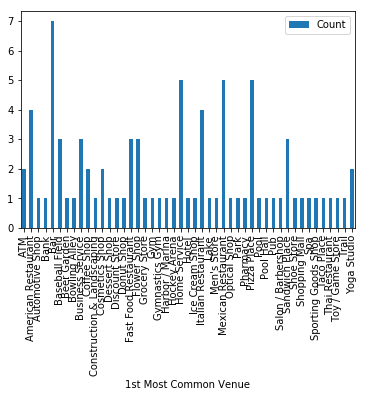

<Figure size 21600x7200 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
top_venue_count = pd.DataFrame({"Count" : restricted_cities.groupby("1st Most Common Venue").size()}).reset_index()
top_venue_count.plot(kind="bar", x="1st Most Common Venue", y="Count")
plt.show()

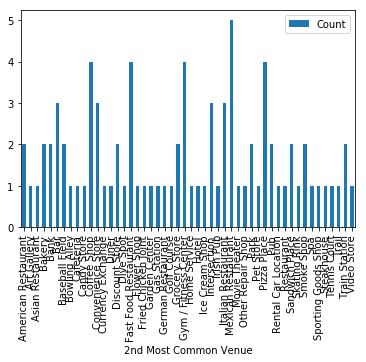

In [33]:
second_top = pd.DataFrame({"Count" : restricted_cities.groupby("2nd Most Common Venue").size()}).reset_index()
second_top.plot(kind="bar", x="2nd Most Common Venue", y="Count")
plt.show()

In [40]:
cities_with_size.sort_values(by=["Venue"],ascending=False)

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
13,Chicago,731,731,731,731,731,731
58,Oak Park,135,135,135,135,135,135
59,Palatine,91,91,91,91,91,91
23,Evanston,80,80,80,80,80,80
2,Arlington Heights,74,74,74,74,74,74
20,Des Plaines,68,68,68,68,68,68
28,Geneva,65,65,65,65,65,65
21,Elgin,47,47,47,47,47,47
65,Schaumburg,41,41,41,41,41,41
38,Highwood,40,40,40,40,40,40
